In [9]:
import matplotlib as plt
plt.rcParams["figure.autolayout"] = True # to for tight_layout()
import pymc as pm
import pytensor as pt
import numpy as np

In [37]:
with pm.Model() as model_dirac:
    num_vars = 5

    x = pm.DiscreteUniform('x',0,125,shape=num_vars)

    for i in range(num_vars-1):
        pm.DiracDelta(f'obs{i}', pt.tensor.le(x[i], x[i+1]), observed=True)

    pm.DiracDelta('obs_median_1', pt.tensor.eq(x[2], 30), observed=True)

    pm.DiracDelta(f'obs_sum', pt.tensor.eq(x[0] + x[1] + x[2] + x[3] + x[4], 38*5), observed=True)

    # covariance matrix of proposal dist (MultivariateNormal)
    S = np.zeros((num_vars,num_vars), np.int64)
    np.fill_diagonal(S,100)

    # config metropolis
    step = pm.Metropolis(
        S=S, # set new proposal dist
        tune_interval=1000 # incrase steps between samples?
    )

    trace = pm.sample(
        draws=int(1e5),
        tune=1000, # a lot of tunning steps
        chains=2,
        progressbar=False,
        step = step, # set MH with modified proposal
        initvals={'x': [0,30,30,58,72]} # we must a satisfying initial state, otherwise it does not work...
    ) 

Multiprocess sampling (2 chains in 2 jobs)


Metropolis: [x]


Sampling 2 chains for 1_000 tune and 100_000 draw iterations (2_000 + 200_000 draws total) took 34 seconds.


We recommend running at least 4 chains for robust computation of convergence diagnostics


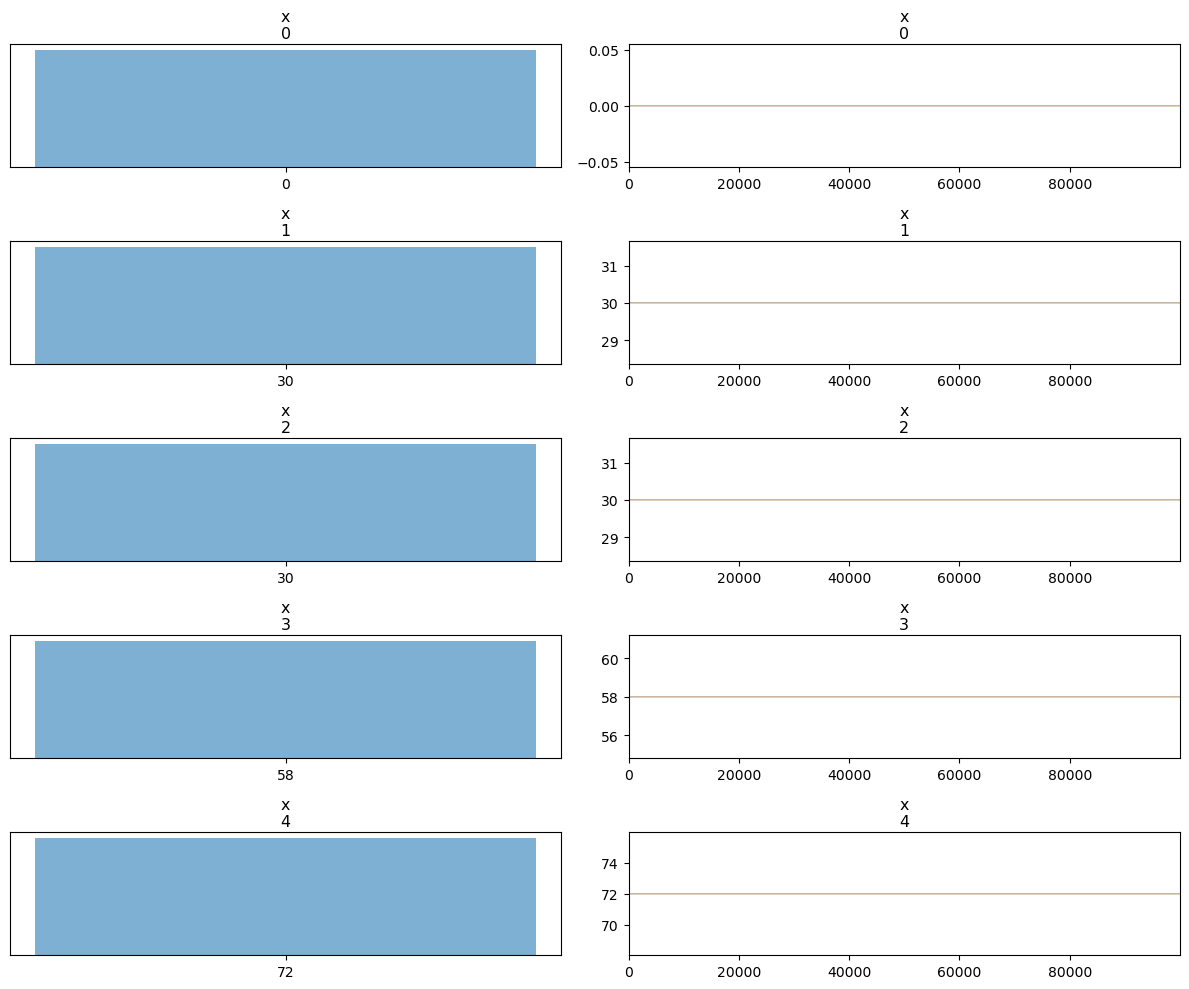

In [38]:
pm.plot_trace(trace, var_names=['x'] , combined=False, compact=False);

In [92]:
with pm.Model() as model_approx_normal:
    num_vars = 5
    precision = 0.01

    x = pm.DiscreteUniform('x',0,125,shape=num_vars)

    for i in range(num_vars-1):
        c = pm.Deterministic(f'x{i} < x{i+1}', pt.tensor.le(x[i],x[i+1]))
        pm.Normal(f'obs{i}', mu=c, sigma=precision, observed=True)

    pm.Normal('obs_median_1', mu=x[2], sigma=precision, observed=30)

    sum_vars = pm.Deterministic('sum_vars',x[0] + x[1] + x[2] + x[3] + x[4])

    pm.Normal(f'obs_sum', mu=sum_vars, sigma=precision, observed=38*5)

    # covariance matrix of proposal dist (MultivariateNormal)
    S = np.zeros((num_vars,num_vars), np.int64)
    np.fill_diagonal(S,100)

    # config metropolis
    step = pm.Metropolis(
        S=S, # set new proposal dist
        tune_interval=1000 # incrase steps between samples?
    )

    trace2 = pm.sample(
        draws=int(1e5),
        tune=1000, # a lot of tunning steps
        chains=2,
        progressbar=False,
        step = step#, # set MH with modified proposal
        # initvals={'x': [0,30,30,58,72]} # we do not need this in this case
    ) 

Multiprocess sampling (2 chains in 2 jobs)


Metropolis: [x]


/home/pardo/miniconda3/envs/prpro-2024/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


/home/pardo/miniconda3/envs/prpro-2024/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 2 chains for 1_000 tune and 100_000 draw iterations (2_000 + 200_000 draws total) took 34 seconds.


We recommend running at least 4 chains for robust computation of convergence diagnostics


/home/pardo/miniconda3/envs/prpro-2024/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/pardo/miniconda3/envs/prpro-2024/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/pardo/miniconda3/envs/prpro-2024/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/pardo/miniconda3/envs/prpro-2024/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single valu

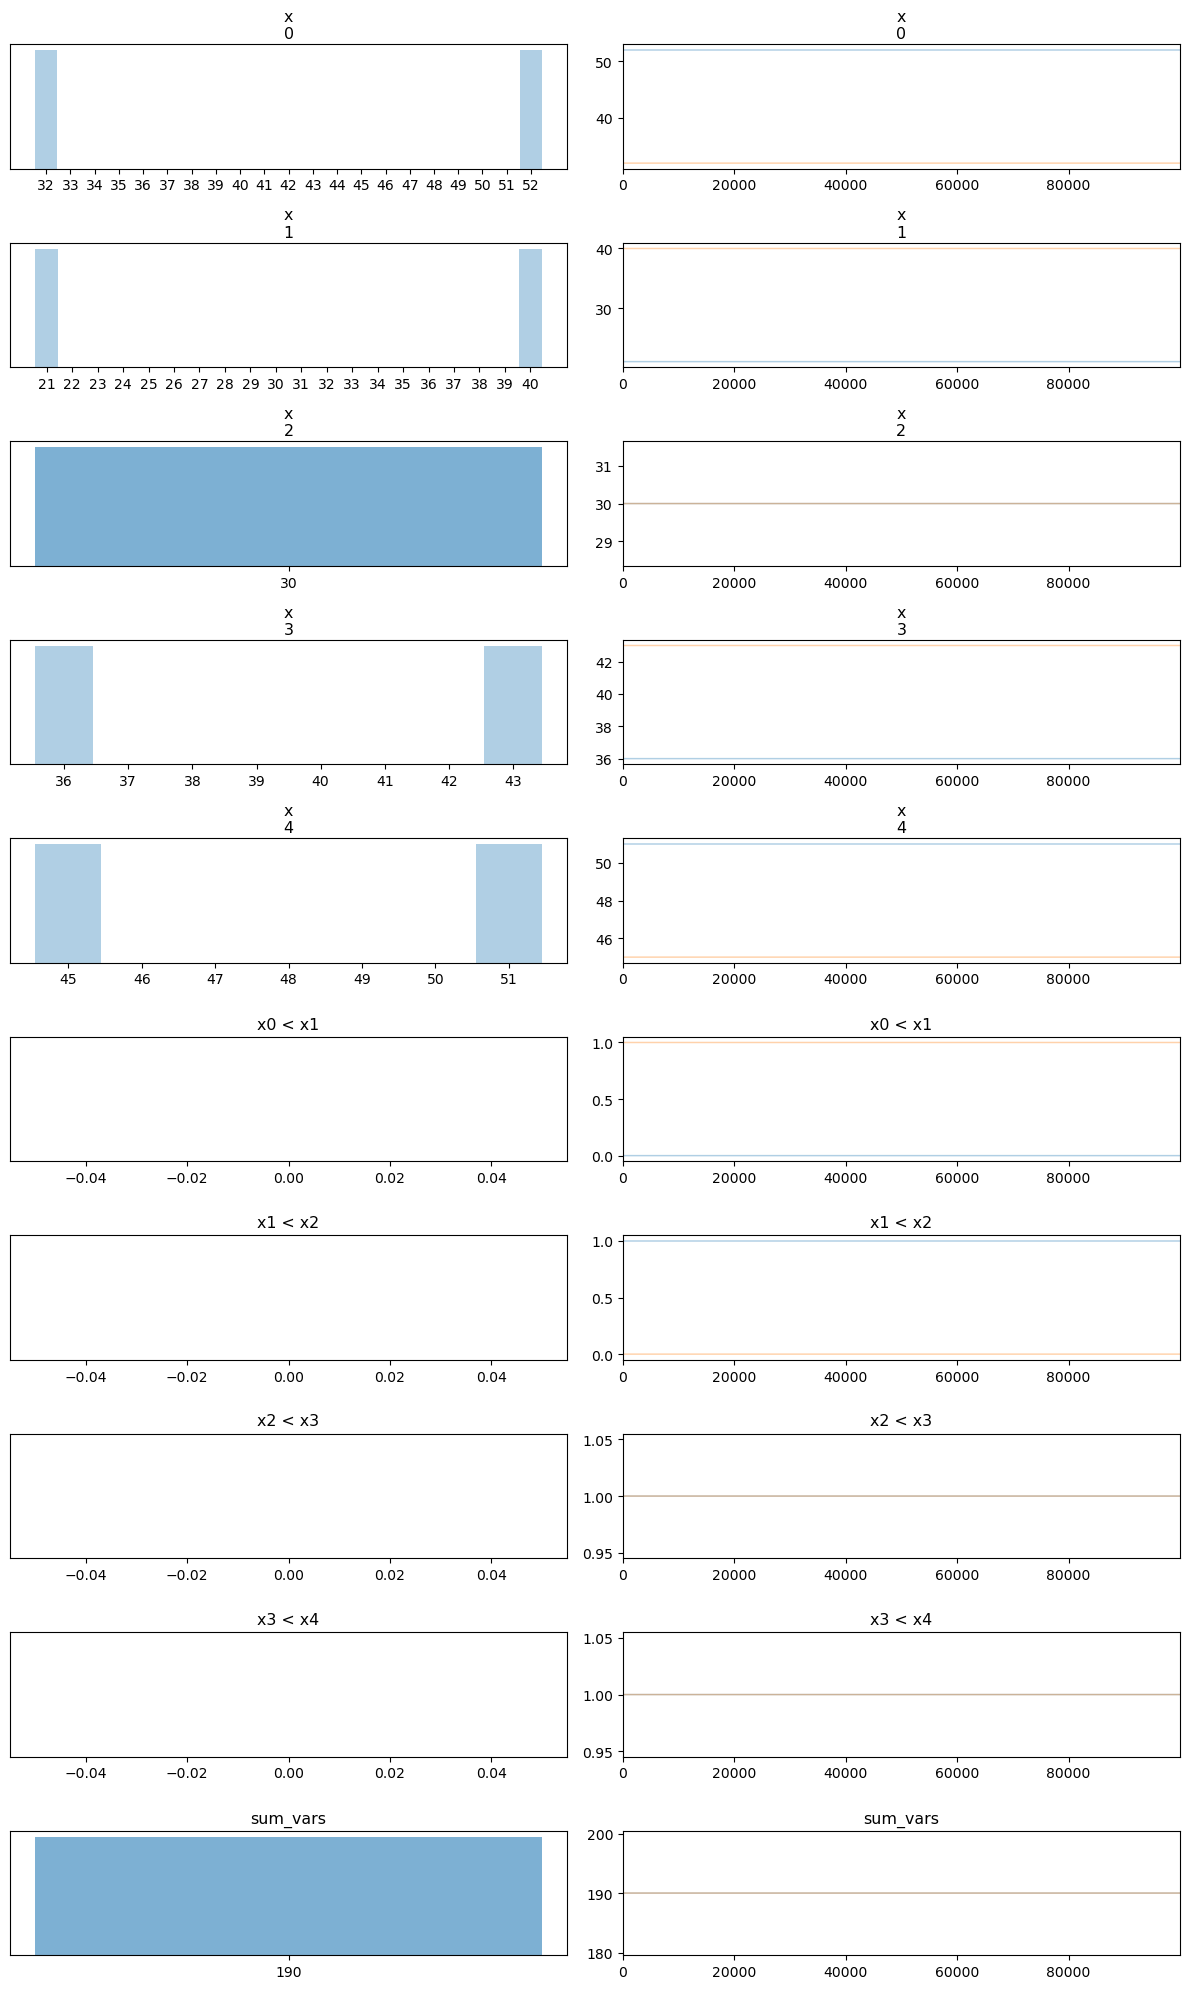

In [93]:
pm.plot_trace(trace2, compact=False);

In [96]:
np.unique(trace2.posterior.x, axis=1)

array([[[52, 21, 30, 36, 51]],

       [[32, 40, 30, 43, 45]]])

In [115]:
# now we try with a Poisson proposal
with pm.Model() as model_dirac_poisson:
    num_vars = 5

    x = pm.DiscreteUniform('x',0,125,shape=num_vars)

    for i in range(num_vars-1):
        c = pm.Deterministic(f'x{i} < x{i+1}', pt.tensor.le(x[i],x[i+1]))
        pm.DiracDelta(f'obs{i}', c, observed=True)

    # pm.DiracDelta('obs_median_1', pt.tensor.eq(x[2], 30), observed=True)

    # pm.DiracDelta(f'obs_sum', pt.tensor.eq(x[0] + x[1] + x[2] + x[3] + x[4], 38*5), observed=True)

    # rates for each variable of a vector of Poisson distributions
    S = np.repeat(20,num_vars)

    # config metropolis
    step = pm.Metropolis(
        proposal_dist = pm.PoissonProposal,
        S=S, # set new proposal dist
        tune_interval=10_000 # increase steps between samples?
    )

    trace3 = pm.sample(
        draws=int(10_000),
        tune=1000, # a lot of tunning steps
        chains=2,
        progressbar=False,
        step = step, # set MH with modified proposal
        initvals={'x': [0,30,30,58,72]} # we must a satisfying initial state, otherwise it does not work...
    ) 

Multiprocess sampling (2 chains in 2 jobs)


Metropolis: [x]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 4 seconds.


We recommend running at least 4 chains for robust computation of convergence diagnostics


/home/pardo/miniconda3/envs/prpro-2024/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/pardo/miniconda3/envs/prpro-2024/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/pardo/miniconda3/envs/prpro-2024/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/pardo/miniconda3/envs/prpro-2024/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single valu

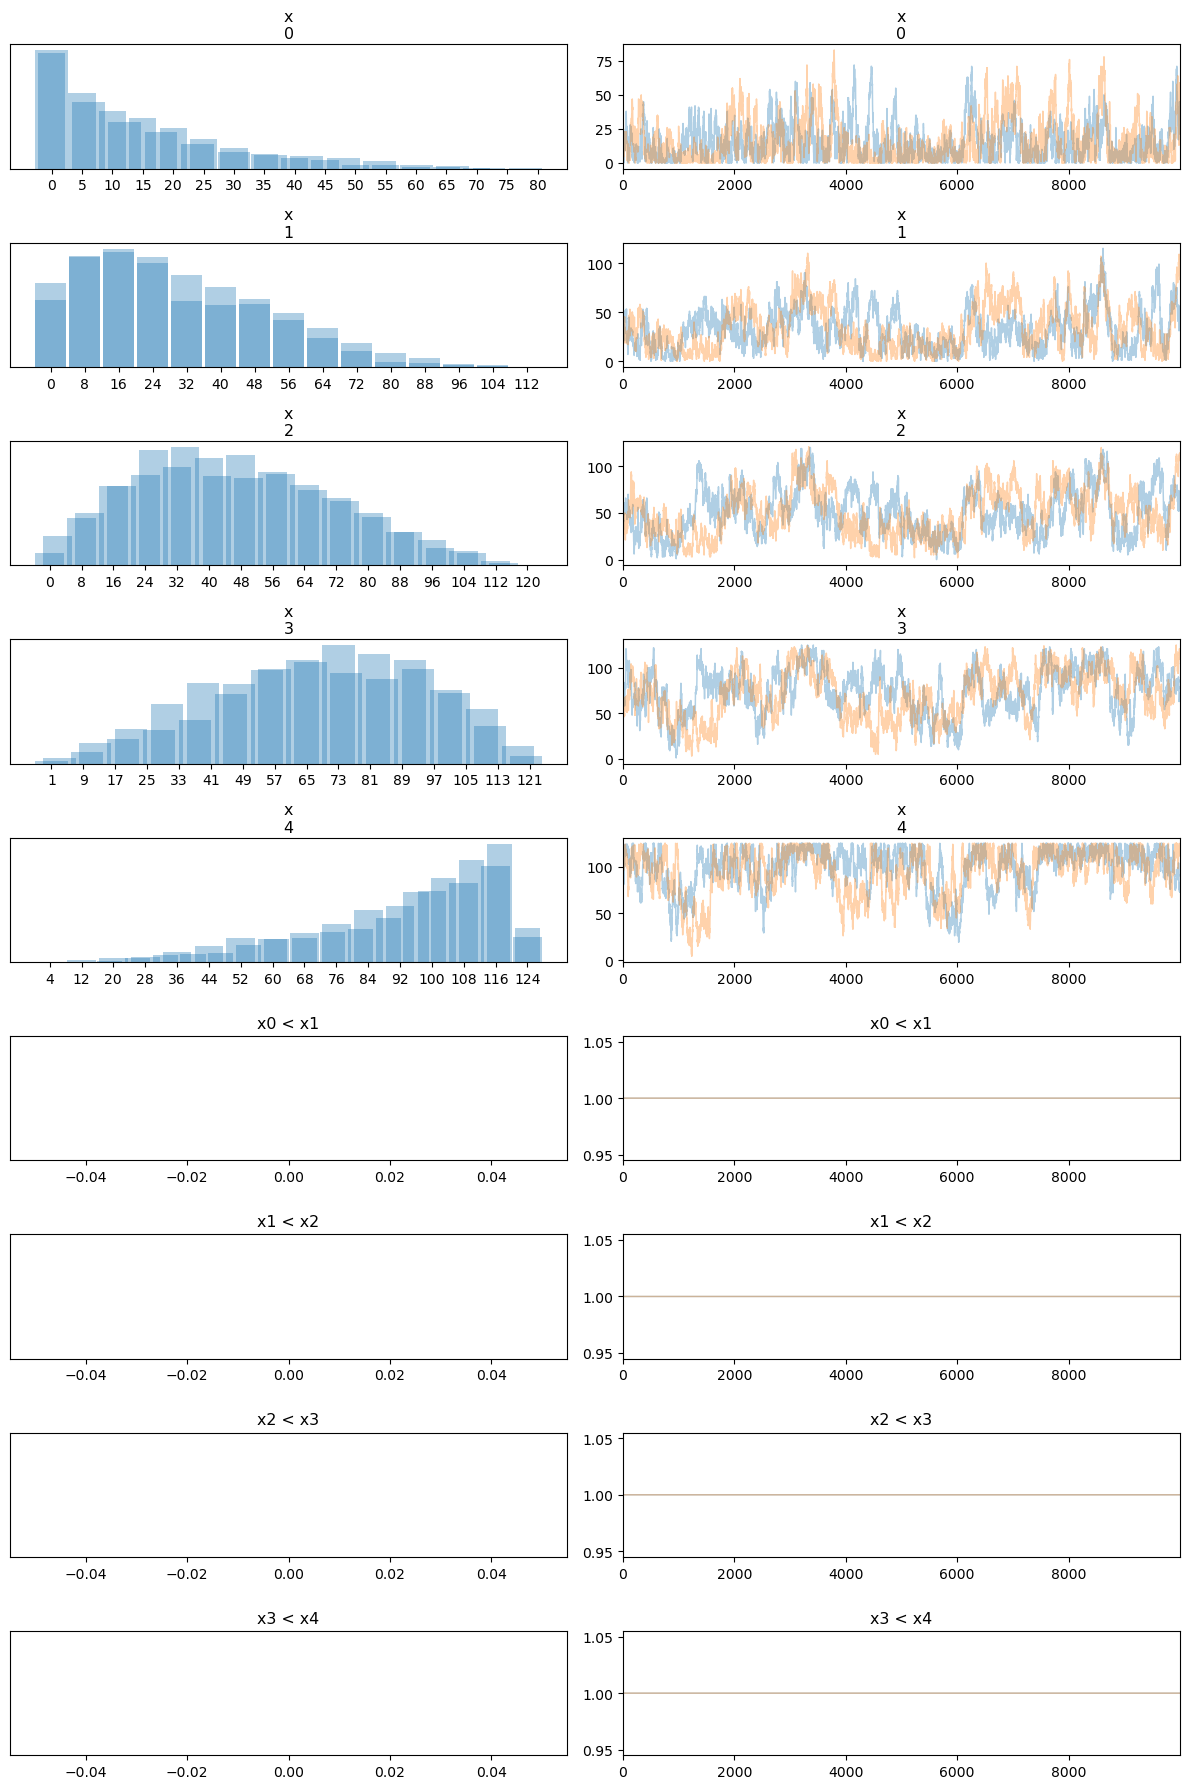

In [116]:
pm.plot_trace(trace3, compact=False);